# Model 2 : 구독유형 예측모델

## 라이브러리

In [1]:
# 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/colab/data/train.csv', encoding='EUC-KR')
test = pd.read_csv('/content/drive/MyDrive/colab/data/test.csv', encoding='EUC-KR')

In [4]:
# 데이터 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

In [5]:
train.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,subscription_type,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,Low,Basic,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,Medium,Basic,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,Medium,Premium,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,Low,Basic,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,Medium,Basic,3,0,1


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   user_id                            10000 non-null  object 
 1   subscription_duration              10000 non-null  int64  
 2   recent_login_time                  10000 non-null  int64  
 3   average_login_time                 10000 non-null  float64
 4   average_time_per_learning_session  10000 non-null  float64
 5   monthly_active_learning_days       10000 non-null  int64  
 6   total_completed_courses            10000 non-null  int64  
 7   recent_learning_achievement        10000 non-null  float64
 8   abandoned_learning_sessions        10000 non-null  int64  
 9   community_engagement_level         10000 non-null  int64  
 10  preferred_difficulty_level         10000 non-null  object 
 11  subscription_type                  10000 non-null  obje

In [7]:
train.shape

(10000, 15)

## Column 설명
- user_id	: 사용자의 고유 식별자
- subscription_duration	: 사용자가 서비스에 가입한 기간 (월)
- recent_login_time	: 사용자가 마지막으로 로그인한 시간 (일)
- average_login_time	: 사용자의 일반적인 로그인 시간
- average_time_per_learning_session	: 각 학습 세션에 소요된 평균 시간 (분)
- monthly_active_learning_days	: 월간 활동적인 학습 일수
- total_completed_courses	: 완료한 총 코스 수
- recent_learning_achievement	: 최근 학습 성취도
- abandoned_learning_sessions	: 중단된 학습 세션 수
- community_engagement_level	: 커뮤니티 참여도
- preferred_difficulty_level	: 선호하는 난이도
- subscription_type	: 구독 유형
- customer_inquiry_history	: 고객 문의 이력
- payment_pattern	: 사용자의 지난 3개월 간의 결제 패턴을 10진수로 표현한 값.
 - 7: 3개월 모두 결제함
 - 6: 첫 2개월은 결제했으나 마지막 달에는 결제하지 않음
 - 5: 첫 달과 마지막 달에 결제함
 - 4: 첫 달에만 결제함
 - 3: 마지막 2개월에 결제함
 - 2: 가운데 달에만 결제함
 - 1: 마지막 달에만 결제함
 - 0: 3개월 동안 결제하지 않음
- target	: 사용자가 다음 달에도 구독을 계속할지 (1) 또는 취소할지 (0)를 표시

## X, Y 변수 분리

In [8]:
# test데이터 copy
test2 = test.copy()

In [9]:
# test 데이터에서 '구독유형' 변수 삭제
test2 = test2.drop(['subscription_type'], axis=1)

In [10]:
# y값이 목표변수
y_train = train['subscription_type']

In [11]:
y_train=pd.DataFrame(y_train)

In [36]:
ID = test['user_id']

In [13]:
# x값은 종속변수
x_train = train.drop(['subscription_type'], axis=1)

## 범주형 라벨인코딩

In [14]:
# 범주형 컬럼 확인
print(x_train['preferred_difficulty_level'].unique())

['Low' 'Medium' 'High']


In [15]:
# train 라벨인코딩
x_train['preferred_difficulty_level']=x_train['preferred_difficulty_level'].map({'Low':0,'Medium':1,'High':2})
y_train['subscription_type'] = y_train['subscription_type'].map({'Basic':0, 'Premium':1})

# test 라벨인코딩
test['preferred_difficulty_level']=test['preferred_difficulty_level'].map({'Low':0,'Medium':1,'High':2})

In [16]:
# 적용되었는지 확인
x_train.head()

,user_id,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,customer_inquiry_history,payment_pattern,target
0,b919c29d,13,14,14.946163,8.427187,18,16,68.360455,3,4,0,4,5,0
1,a0a60abb,16,18,18.453224,72.646087,16,13,97.567322,2,3,1,1,6,1
2,b9f171ae,22,1,16.195228,21.774492,13,14,94.358763,3,4,1,0,7,1
3,5dc0ba8b,1,19,17.628656,42.659066,19,18,70.153228,0,3,0,1,0,1
4,65c83654,4,5,21.390656,30.744287,19,10,81.917908,2,4,1,3,0,1


## MinMax 스케일링
- outlier가 많은 3개의 열에 minmax 스케일링을 적용

In [17]:
# 정규화 스케일링 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [18]:
model = MinMaxScaler()

In [19]:
col = x_train[['average_login_time', 'average_time_per_learning_session', 'recent_learning_achievement']]
model.fit(col)

MinMaxScaler()

In [20]:
scaled = model.transform(x_train[['average_login_time', 'average_time_per_learning_session', 'recent_learning_achievement']])

In [21]:
scaled_df = pd.DataFrame(scaled, columns=[['average_login_time', 'average_time_per_learning_session', 'recent_learning_achievement']])

In [22]:
# 정규화 스케일링
x_train['average_login_time'] = scaled_df['average_login_time']
x_train['average_time_per_learning_session'] = scaled_df['average_time_per_learning_session']
x_train['recent_learning_achievement'] = scaled_df['recent_learning_achievement']

In [23]:
# user_id drop
x_train = x_train.drop(columns=['user_id'])

In [24]:
# 적용되었는 확인
x_train.head()

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,customer_inquiry_history,payment_pattern,target
0,13,14,0.510710,0.016719,18,16,0.422657,3,4,0,4,5,0
1,16,18,0.653087,0.144299,16,13,0.803441,2,3,1,1,6,1
2,22,1,0.561419,0.043235,13,14,0.761609,3,4,1,0,7,1
3,1,19,0.619612,0.084726,19,18,0.446031,0,3,0,1,0,1
4,4,5,0.772338,0.061055,19,10,0.599412,2,4,1,3,0,1


In [25]:
# 상관관계 확인
x_train.corr()

,subscription_duration,recent_login_time,average_login_time,average_time_per_learning_session,monthly_active_learning_days,total_completed_courses,recent_learning_achievement,abandoned_learning_sessions,community_engagement_level,preferred_difficulty_level,customer_inquiry_history,payment_pattern,target
subscription_duration,1.000000,0.014754,-0.000031,0.006324,0.002193,-0.001662,0.007875,0.014414,0.002114,-0.016938,-0.005174,-0.003704,-0.006710
recent_login_time,0.014754,1.000000,-0.006113,-0.004650,-0.015338,-0.000142,0.005768,-0.015882,-0.005486,0.008860,0.011653,0.008737,-0.004184
average_login_time,-0.000031,-0.006113,1.000000,-0.007382,0.002294,-0.012416,-0.005967,0.013661,0.003129,-0.008765,0.009768,0.012508,-0.008527
average_time_per_learning_session,0.006324,-0.004650,-0.007382,1.000000,-0.001678,0.081332,-0.008231,-0.014488,0.086485,-0.086796,-0.001397,-0.002460,0.118261
monthly_active_learning_days,0.002193,-0.015338,0.002294,-0.001678,1.000000,0.004816,0.030110,-0.007512,0.000700,-0.012973,-0.016704,-0.003457,0.004876
total_completed_courses,-0.001662,-0.000142,-0.012416,0.081332,0.004816,1.000000,-0.002416,0.012322,0.266026,-0.255945,-0.014949,-0.013646,-0.004040
recent_learning_achievement,0.007875,0.005768,-0.005967,-0.008231,0.030110,-0.002416,1.000000,0.002115,-0.000810,-0.004940,0.005612,-0.003968,0.002294
abandoned_learning_sessions,0.014414,-0.015882,0.013661,-0.014488,-0.007512,0.012322,0.002115,1.000000,0.015877,-0.023684,-0.007322,0.010299,-0.019636
community_engagement_level,0.002114,-0.005486,0.003129,0.086485,0.000700,0.266026,-0.000810,0.015877,1.000000,-0.217334,0.005574,-0.015914,0.009641
preferred_difficulty_level,-0.016938,0.008860,-0.008765,-0.086796,-0.012973,-0.255945,-0.004940,-0.023684,-0.217334,1.000000,0.012926,0.018934,0.012860


## 데이터 분리

In [26]:
# 라이브러리
from sklearn.model_selection import train_test_split

In [27]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(x_train, y_train, test_size=0.2, random_state=12)

In [28]:
# ID = pd.DataFrame(ID)

In [29]:
test2 = test2.drop(columns=['user_id'])

## 모델링

In [30]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, confusion_matrix

In [31]:
# XGBoost 분류기 생성
model = XGBClassifier()
scorer = make_scorer(f1_score, average='macro')

In [32]:
model.fit(X_TRAIN, Y_TRAIN)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
train_pred = model.predict(X_TRAIN)
test_pred = model.predict(X_TEST)

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(Y_TRAIN, train_pred)) # 학습율
print(accuracy_score(Y_TEST, test_pred))

0.773875
0.7765


## 하이퍼파라미터 조정 및 그리드서치

In [ ]:
# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.3, 0.5, 0.55, 0.6, 0.7],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'n_estimators': [104, 109, 210, 300, 350, 500]
}

In [ ]:
# 그리드 서치 수행
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_TRAIN, Y_TRAIN)

# 최적의 하이퍼파라미터 및 성능 확인
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 3 folds for each of 16200 candidates, totalling 48600 fits
{'colsample_bytree': 0.5, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 109, 'subsample': 0.6}
0.769500586620221


In [34]:
# 위결과를 바탕으로 코드 실행
# 조정하기 전보다 더 오른 것을 확인 가
model = xgb.XGBClassifier(
    n_estimators=109,
    max_depth=1,
    random_state=12,
    n_jobs=-1,
    colsample_bytree=0.5,
    min_child_weight=3,
    subsample=0.6
)
model.fit(X_TRAIN, Y_TRAIN)

train_pred = model.predict(X_TRAIN)
test_pred = model.predict(X_TEST)

print(accuracy_score(Y_TRAIN, train_pred))
print(accuracy_score(Y_TEST, test_pred))

0.772
0.7815


## 혼동행렬

[[984 207]
 [230 579]]


Text(0.5, 23.52222222222222, 'Predicted')

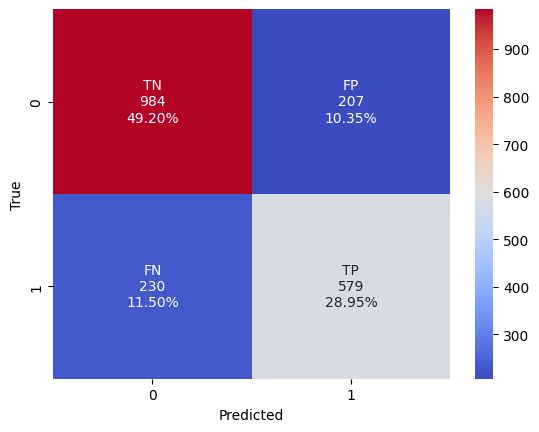

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_TEST,test_pred))
cf_matrix = confusion_matrix(Y_TEST, test_pred)
cf_matrix

group_names = ['TN','FP', 'FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
plt.ylabel('True')
plt.xlabel('Predicted')

## 중요 변수 확인

In [ ]:
model = xgb.XGBClassifier(learning=0.3, max_depth=1,
                          n_estimators=218, subsample=0.6, random_state=12)

# model = xgb.XGBClassifier(learning=0.3, max_depth=5,
#                           n_estimators=1000, subsample=0.5, random_state=12)
model.fit(X_TRAIN, Y_TRAIN)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:26:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "learning" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning=0.3, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=218, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# 중요 변수
model.feature_importances_

array([0.02242856, 0.02461317, 0.02067368, 0.03698606, 0.02499714,
       0.1999112 , 0.02327535, 0.02486021, 0.4513072 , 0.10174616,
       0.0210477 , 0.02667669, 0.0214768 ], dtype=float32)

In [ ]:
feature_imp = pd.DataFrame({
    'features': X_TRAIN.columns,
    'values' : model.feature_importances_,
})

In [ ]:
pd.options.display.float_format = '{:.6f}'.format

In [ ]:
feature_imp.sort_values(by='values', ascending=False)

,features,values
8,community_engagement_level,0.451307
5,total_completed_courses,0.199911
9,preferred_difficulty_level,0.101746
3,average_time_per_learning_session,0.036986
11,payment_pattern,0.026677
4,monthly_active_learning_days,0.024997
7,abandoned_learning_sessions,0.024860
1,recent_login_time,0.024613
6,recent_learning_achievement,0.023275
0,subscription_duration,0.022429


<Figure size 10000x20000 with 0 Axes>

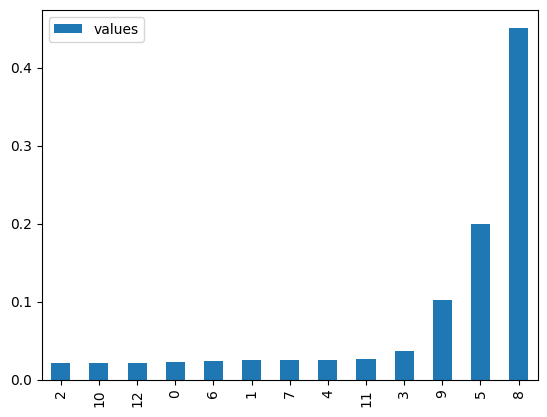

In [ ]:
plt.figure(figsize=(100,200))
feature_imp.sort_values(by='values', ascending=True).plot(kind='bar')
plt.show()

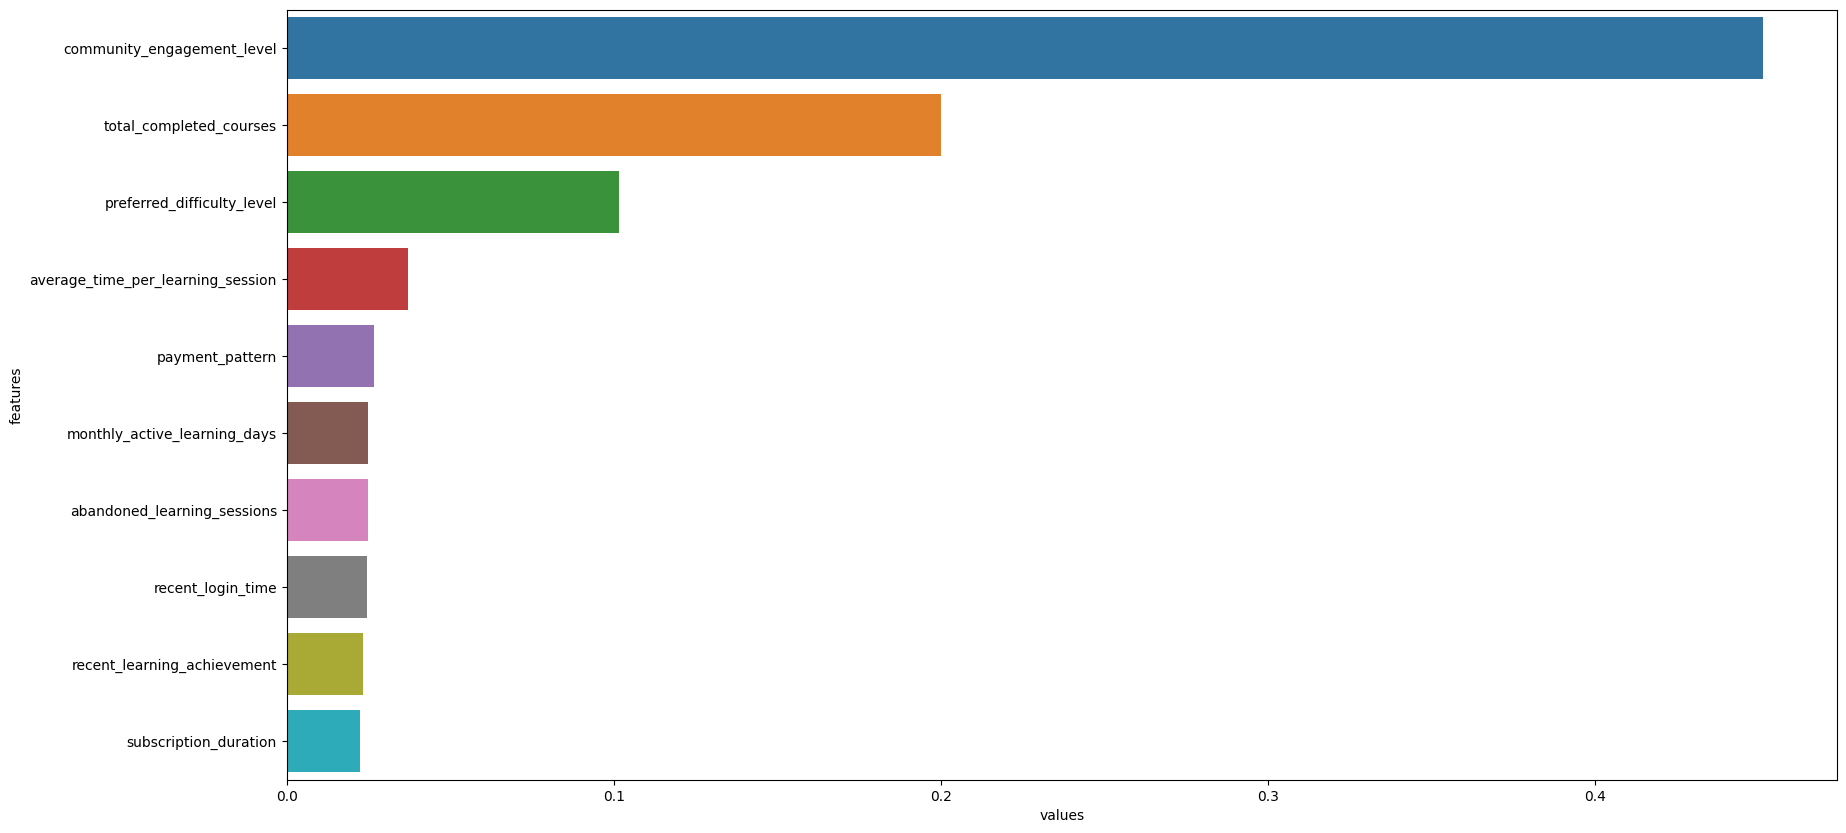

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='values', y='features',
            data= feature_imp.sort_values(by='values', ascending=False).head(10))
plt.show()